<a href="https://colab.research.google.com/github/sotetsuk/pgx/blob/sotetsuk%2Fcolab%2Fv2/colab/baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pgx baseline models

Pgx offers several baseline models. These models are not as powerful as state-of-the-art (SoTA) models, but they serve as useful opponents for Pgx users to grasp the learning process of their algorithm.

In [1]:
!pip install pgx dm-haiku  # additionaly requires Haiku library

  Using cached dm_haiku-0.0.11-py3-none-any.whl.metadata (19 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.0 MB/s eta 0:00:00
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached jmp-0.0.4-py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.1 MB/s eta 0:00:00
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached flax-0.7.5-py3-none-any.whl.metadata (10 kB)
  Using cached msgpack-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached optax-0.1.7-py3-none-any.whl.metadata (13 kB)
  Using cached orbax_checkpoint-0.4.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorstore-0.1.48-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached rich-13.6.0-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.

In [2]:
import jax
import jax.numpy as jnp
import pgx

import haiku as hk
from IPython.display import *

print(pgx.__version__)
print(hk.__version__)

2.0.1
0.0.11


## Run self-play with greedy action selection

Note

- `pgx.make_baseline_model` will download the model file from Google Drive and stores it to `<curr_dir>/baselines/` by default
- This example does not use MCTS for the simplicty. You can enhance the model by uzing [mctx](https://github.com/deepmind/mctx) library.

In [4]:
env_id = "go_9x9"
model_id = "go_9x9_v0"

env = pgx.make(env_id)
model = pgx.make_baseline_model(model_id)

init_fn = jax.jit(jax.vmap(env.init))
step_fn = jax.jit(jax.vmap(env.step))

states = []
batch_size = 1
keys = jax.random.split(jax.random.PRNGKey(0), batch_size)
state = init_fn(keys)
states.append(state)
while not (state.terminated | state.truncated).all():
    logits, value = model(state.observation)
    action = logits.argmax(axis=-1)
    state = step_fn(state, action)
    states.append(state)

AssertionError: 

## See how it plays

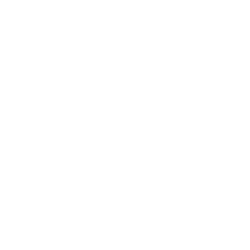

In [4]:
pgx.save_svg_animation(states, f"{env_id}.svg", frame_duration_seconds=0.5)
display_svg(SVG(f"{env_id}.svg"))

## Other baseline models

So far, we support these baseline models:

In [5]:
pgx.BaselineModelId

typing.Literal['animal_shogi_v0', 'gardner_chess_v0', 'go_9x9_v0', 'hex_v0', 'othello_v0', 'minatar-asterix_v0', 'minatar-breakout_v0', 'minatar-freeway_v0', 'minatar-seaquest_v0', 'minatar-space_invaders_v0']

In [6]:
import jax
import jax.numpy as jnp
import pgx

seed = 42
batch_size = 10
key = jax.random.PRNGKey(seed)


def act_randomly(rng_key, obs, mask):
    """Ignore observation and choose randomly from legal actions"""
    del obs
    probs = mask / mask.sum()
    logits = jnp.maximum(jnp.log(probs), jnp.finfo(probs.dtype).min)
    return jax.random.categorical(rng_key, logits=logits, axis=-1)


# Load the environment
env = pgx.make("go_9x9")
init_fn = jax.jit(jax.vmap(env.init))
step_fn = jax.jit(jax.vmap(env.step))

# Initialize the states
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, batch_size)
state = init_fn(keys)

# Run random simulation
while not (state.terminated | state.truncated).all():
    key, subkey = jax.random.split(key)
    action = act_randomly(subkey, state.observation, state.legal_action_mask)
    state = step_fn(state, action)  # state.reward (2,)

In [7]:
import jax
import jax.numpy as jnp
import pgx
from pgx.experimental.utils import act_randomly

seed = 42
batch_size = 10
key = jax.random.PRNGKey(seed)

# Prepare agent A and B
#   Agent A: random player
#   Agent B: baseline player provided by Pgx
A = 0
B = 1

# Load the environment
env = pgx.make("go_9x9")
init_fn = jax.jit(jax.vmap(env.init))
step_fn = jax.jit(jax.vmap(env.step))

# Prepare baseline model
# Note that it additionaly requires Haiku library ($ pip install dm-haiku)
model_id = "go_9x9_v0"
model = pgx.make_baseline_model(model_id)

# Initialize the states
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, batch_size)
state = init_fn(keys)
print(f"Game index: {jnp.arange(batch_size)}")  #  [0 1 2 3 4 5 6 7 8 9]
print(f"Black player: {state.current_player}")  #  [1 1 0 1 0 0 1 1 1 1]
# In other words
print(f"A is black: {state.current_player == A}")  # [False False  True False  True  True False False False False]
print(f"B is black: {state.current_player == B}")  # [ True  True False  True False False  True  True  True  True]

# Run simulation
R = state.rewards
while not (state.terminated | state.truncated).all():
    # Action of random player A
    key, subkey = jax.random.split(key)
    action_A = jax.jit(act_randomly)(subkey, state)
    # Greedy action of baseline model B
    logits, value = model(state.observation)
    action_B = logits.argmax(axis=-1)

    action = jnp.where(state.current_player == A, action_A, action_B)
    state = step_fn(state, action)
    R += state.rewards

print(f"Return of agent A = {R[:, A]}")  # [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
print(f"Return of agent B = {R[:, B]}")  # [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Game index: [0 1 2 3 4 5 6 7 8 9]
Black player: [0 1 1 1 0 0 1 1 1 1]
A is black: [ True False False False  True  True False False False False]
B is black: [False  True  True  True False False  True  True  True  True]


AssertionError: Pgx v2.0.0 changes pgx.experimental.act_randomly to reveive legal_action_mask instead of state:

  * <  v2.0.0: act_randomly(rng, state)
  * >= v2.0.0: act_randomly(rng, state.legal_action_mask)

Note that codes under pgx.experimental are subject to change without notice.